In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

In [46]:
# Data Preprocessing
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

In [ ]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Validation Loss: 0.0550
Epoch 2/1000, Validation Loss: 0.0454
Epoch 3/1000, Validation Loss: 0.0447
Epoch 4/1000, Validation Loss: 0.0406
Epoch 5/1000, Validation Loss: 0.0446
Epoch 6/1000, Validation Loss: 0.0360
Epoch 7/1000, Validation Loss: 0.0404
Epoch 8/1000, Validation Loss: 0.0374
Epoch 9/1000, Validation Loss: 0.0369
Epoch 10/1000, Validation Loss: 0.0378
Early stopping!


In [ ]:
# Evaluation
model.eval()
predictions = []
true_values = []  # To store the true values

with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())
        true_values.extend(y_batch.numpy().tolist())  # Store the true values

# Convert predictions and true values to numpy arrays for calculations
predictions = np.array(predictions)
true_values = np.array(true_values)

# Rescale the predictions and true values using the scaler (if needed)
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_values_rescaled = scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions_rescaled - true_values_rescaled) ** 2))
print(f"Score (RMSE): {rmse:.4f}")

# Calculate MAE (Mean Absolute Error)
mae = np.mean(np.abs(predictions_rescaled - true_values_rescaled))
print(f"Score (MAE): {mae:.4f}")

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((predictions_rescaled - true_values_rescaled) / true_values_rescaled)) * 100
print(f"Score (MAPE): {mape:.4f}")


Score (RMSE): 16.1578
Score (MAE): 11.9612
Score (MAPE): 19483676.9283


In [39]:
!pip install nixtla

In [40]:
from nixtla import NixtlaClient

In [41]:
nixtla_client = NixtlaClient(
    api_key = 'nixak-DOAalmr8omZLv5CNy2A26mJAaKMv5FbvqwDth4wKx4K27Z5cmJ9Dtk6Zidmvg4NJzsYGqll8X7vrCSIY'
)

In [42]:
nixtla_client.validate_api_key()

True

In [43]:
import pandas as pd
print(df.head());

        year     month        day     dec_year   sn_value  sn_error  obs_num  \
0 1970-01-01  6.514939  15.730695  1933.237011  85.583711  7.138131  4.69825   

    unused1  
0  0.998522  


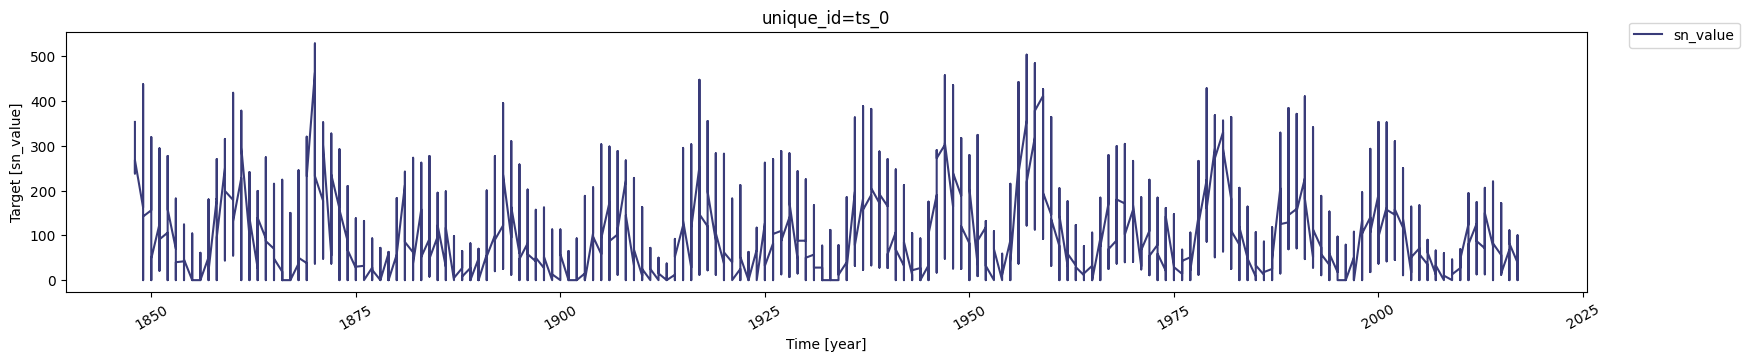

In [47]:
nixtla_client.plot(df, time_col='year', target_col='sn_value')

In [48]:
print(df.columns)


Index(['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error', 'obs_num',
       'unused1'],
      dtype='object')


In [49]:
import pandas as pd

# Assuming 'datetime' is already present
# Ensure 'datetime' is in datetime format
df['year'] = pd.to_datetime(df['year'])

# Resample to the desired frequency (monthly start)
df = df.set_index('year').resample('MS').mean().reset_index()

# Handle missing values (forward fill or interpolate if needed)
df['sn_value'] = df['sn_value'].fillna(method='ffill')  # You can also use interpolate()

# Use the 'datetime' column as the 'time_col' in the forecast function
timegpt_fcst_df = nixtla_client.forecast(
    df=df,
    h=12,
    freq='MS',  # Monthly Start
    time_col='year',
    target_col='sn_value'
)

# Display forecast
print(timegpt_fcst_df.head())


<ipython-input-49-e1bdb7742673>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['sn_value'] = df['sn_value'].fillna(method='ffill')  # You can also use interpolate()
/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


        year    TimeGPT
0 1970-02-01  236.83925
1 1970-03-01  196.39386
2 1970-04-01  224.01135
3 1970-05-01  274.53802
4 1970-06-01  346.13070


In [50]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=12, freq='MS', time_col='year', target_col='sn_value')
timegpt_fcst_df.head()

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,year,TimeGPT
0,1970-02-01,236.83925
1,1970-03-01,196.39386
2,1970-04-01,224.01135
3,1970-05-01,274.53802
4,1970-06-01,346.13070


In [51]:
df.head()

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused1
0,1970-01-01,6.514939,15.730695,1933.237011,85.583711,7.138131,4.69825,0.998522


In [52]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=36, time_col='year', target_col='sn_value', freq='MS', model='timegpt-1-long-horizon')
timegpt_fcst_df.head()

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,year,TimeGPT
0,1970-02-01,255.17882
1,1970-03-01,213.59973
2,1970-04-01,236.70119
3,1970-05-01,295.27826
4,1970-06-01,392.55005


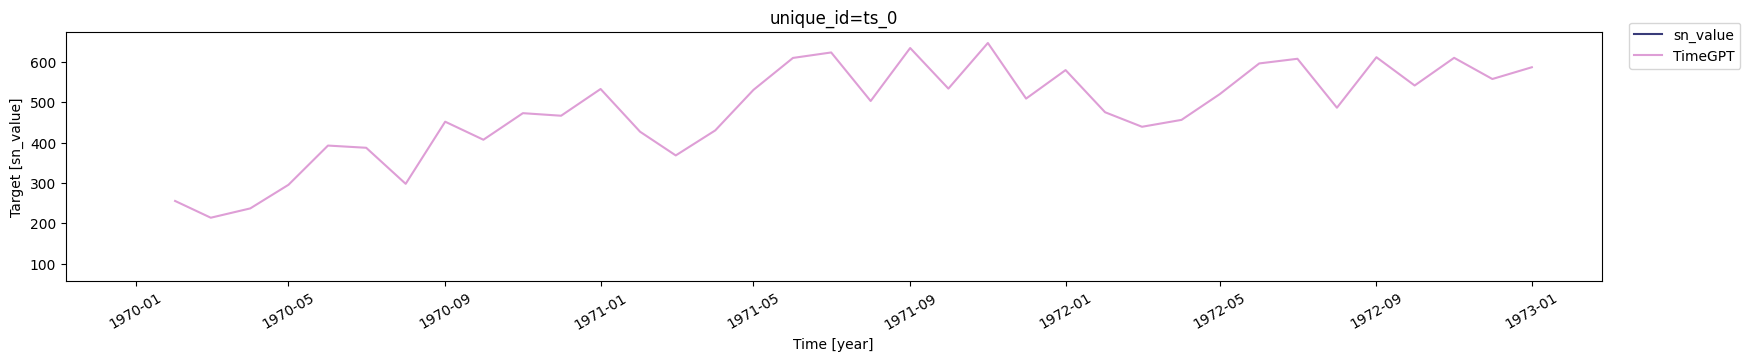

In [53]:
nixtla_client.plot(df, timegpt_fcst_df, time_col='year', target_col='sn_value')

In [65]:
train = df
test = df[-24:]

In [62]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

In [ ]:
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='datetime', target_col='sn_value',
)

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='datetime', target_col='sn_value',
)

In [74]:
import numpy as np
import pandas as pd

# Define column names
names = ['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error', 'obs_num', 'unused1']

# Read the sunspot data
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False
)

# Create a datetime column named 'timestamp'
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day']])

print(df.head())  # Display the first few rows to see the new column

   year  month  day  dec_year  sn_value  sn_error  obs_num  unused1  timestamp
0  1818      1    1  1818.001        -1       NaN        0        1 1818-01-01
1  1818      1    2  1818.004        -1       NaN        0        1 1818-01-02
2  1818      1    3  1818.007        -1       NaN        0        1 1818-01-03
3  1818      1    4  1818.010        -1       NaN        0        1 1818-01-04
4  1818      1    5  1818.012        -1       NaN        0        1 1818-01-05


In [71]:
train = df[:-24]
test = df[-24:]

In [75]:
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='sn_value',
)

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['year', 'month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


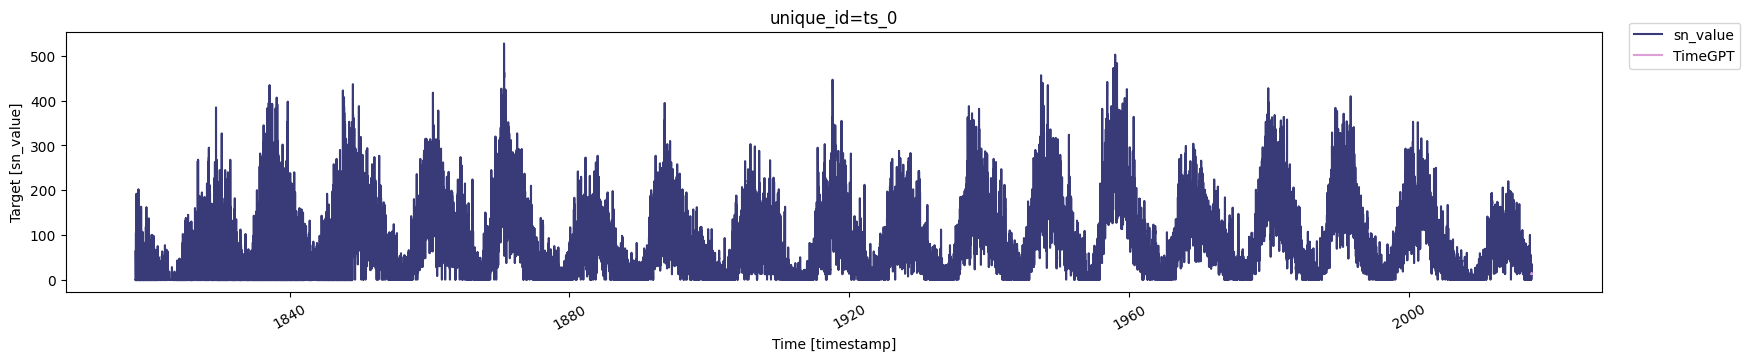

In [76]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='sn_value',
)

In [77]:
train = df[:-24]
test = df[-24:]

In [84]:

from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate
test['unique_id'] = 0
evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="sn_value")
evaluation

,unique_id,metric,year,month,day,dec_year,sn_error,obs_num,unused1,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,1.998917e+03,14.083333,9.166667,1.999380e+03,17.029167,18.333333,18.083333,8.985561,9.022076,9.074039,9.069894,9.152218
1,0,mse,3.995784e+06,262.333333,109.250000,3.997635e+06,394.049583,510.416667,443.333333,141.310653,143.217176,143.414640,141.882450,144.375364


In [85]:
train = df[:-36]
test = df[-36:]

In [87]:
losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

test = test.copy()

for loss in losses:
    preds_df = nixtla_client.forecast(
    df=train,
    h=36,
    finetune_steps=10,
    finetune_loss=loss,
    time_col='timestamp',
    target_col='sn_value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds

/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['year', 'month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['year', 'month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nixtla/nixtla_client.py:365: UserWarning: `df` contains the following exogenous features: ['year', 'month', 'day', 'dec_year', 'sn_error', 'obs_num', 'unused1'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nixtla/ni

In [ ]:
from utilsforecast.losses import mae, mse,mape,smape,rmse
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

pct_improv = []

for loss in losses[1:]:
    evaluation = loss_fct_dict[f'{loss}'](test, models=['TimeGPT_default', f'TimeGPT_{loss}'], id_col='obs_num', target_col='sn_value')
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

In [88]:
from utilsforecast.losses import mae, mse, mape, smape, rmse

# Dictionary of loss functions
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

# Specify the losses to evaluate
losses = ["rmse", "mae", "mse", "mape", "smape"]  # Add 'rmse' here

# Initialize a list to store percentage improvements
pct_improv = []

# Loop through the losses
for loss in losses[1:]:
    # Evaluate the specified loss for both models
    evaluation = loss_fct_dict[f'{loss}'](
        test,
        models=['TimeGPT_default', f'TimeGPT_{loss}'],
        id_col='obs_num',
        target_col='sn_value'
    )

    # Calculate percentage improvement
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

    # Print RMSE if it is the current loss
    if loss == "rmse":
        print(f"RMSE Evaluation:\n{evaluation}")


In [89]:
from utilsforecast.losses import mae, mse, mape, smape, rmse

# Dictionary of loss functions
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

# Specify the losses to evaluate
losses = ["rmse", "mae", "mse", "mape", "smape"]  # Add 'rmse' here

# Initialize a list to store percentage improvements
pct_improv = []

# Loop through the losses
for loss in losses[1:]:
    # Evaluate the specified loss for both models
    evaluation = loss_fct_dict[f'{loss}'](
        test,
        models=['TimeGPT_default', f'TimeGPT_{loss}'],
        id_col='obs_num',
        target_col='sn_value'
    )

    # Calculate percentage improvement
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

    # Print RMSE if it is the current loss
    if loss == "rmse":
        print(f"RMSE Evaluation:\n{evaluation}")


In [91]:
from utilsforecast.losses import mae, mse, mape, smape, rmse

# Dictionary of loss functions
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

# Specify the losses to evaluate
losses = ["rmse", "mae", "mse", "mape", "smape"]  # Add 'rmse' here

# Initialize a list to store percentage improvements
pct_improv = []

# Debugging: Print the list of losses
print(f"Evaluating losses: {losses}")

# Loop through the losses
for loss in losses:
    print(f"Evaluating loss: {loss}")  # Debug: Show the current loss being evaluated
    try:
        # Evaluate the specified loss for both models
        evaluation = loss_fct_dict[f'{loss}'](
            test,
            models=['TimeGPT_default', f'TimeGPT_{loss}'],
            id_col='obs_num',
            target_col='sn_value'
        )

        # Calculate percentage improvement
        pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
        pct_improv.append(round(pct_diff, 2))

        # Print RMSE if it is the current loss
        if loss == "rmse":
            print(f"RMSE Evaluation:\n{evaluation}")
    except Exception as e:
        print(f"Error evaluating {loss}: {e}")


Evaluating losses: ['rmse', 'mae', 'mse', 'mape', 'smape']
Evaluating loss: rmse
RMSE Evaluation:
    obs_num  TimeGPT_default  TimeGPT_rmse
0        10        19.080938     24.342382
1        15         1.347784     11.828415
2        16        11.620644     14.178822
3        17         5.157040     10.770148
4        18        10.130615     20.652225
5        20        10.722004     15.341543
6        21         0.238459      7.686928
7        22         6.839888     13.842980
8        23         6.435131      3.484726
9        25        10.301628     18.393803
10       29         8.734686     12.381996
11       30        16.105200     26.315613
12       32         0.382805      7.162670
13       36        19.291540     24.467274
14       37         7.257553     12.541960
15       39        15.095169     20.104730
16       40         6.535273     13.055965
17       41        12.532621     13.126821
18       42         3.237513      6.487343
19       43        18.308151     23.502456

In [92]:
print(evaluation.columns)


Index(['obs_num', 'TimeGPT_default', 'TimeGPT_smape'], dtype='object')


In [93]:
from utilsforecast.losses import mae, mse, mape, smape, rmse

# Define the loss function dictionary
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape,
}

# Evaluate a single overall loss metric
overall_loss = {}
for loss_name, loss_fct in loss_fct_dict.items():
    # Calculate the loss for the test dataset
    evaluation = loss_fct(test,
                          models=['TimeGPT_default'],
                          id_col='obs_num',
                          target_col='sn_value')

    # Store the mean loss value for this metric
    overall_loss[loss_name] = evaluation['TimeGPT_default'].mean()

# Display the overall losses for all metrics
for loss_name, loss_value in overall_loss.items():
    print(f"Overall {loss_name.upper()}: {loss_value:.4f}")


Overall MAE: 9.4056
Overall MSE: 141.1887
Overall RMSE: 9.9607
Overall MAPE: 0.4308
Overall SMAPE: 0.2731


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Train Loss: 0.1489, Val Loss: 0.1007
Epoch 2/10, Train Loss: 0.1052, Val Loss: 0.1887
Epoch 3/10, Train Loss: 0.0993, Val Loss: 0.2010
Epoch 4/10, Train Loss: 0.0961, Val Loss: 0.1127
Epoch 5/10, Train Loss: 0.0935, Val Loss: 0.1279
Epoch 6/10, Train Loss: 0.0924, Val Loss: 0.0802
Epoch 7/10, Train Loss: 0.0897, Val Loss: 0.0848
Epoch 8/10, Train Loss: 0.0889, Val Loss: 0.0767
Epoch 9/10, Train Loss: 0.0875, Val Loss: 0.0664
Epoch 10/10, Train Loss: 0.0874, Val Loss: 0.0802
MAE: 0.2318
MSE: 0.0802
RMSE: 0.2831
R² Score: 0.8803


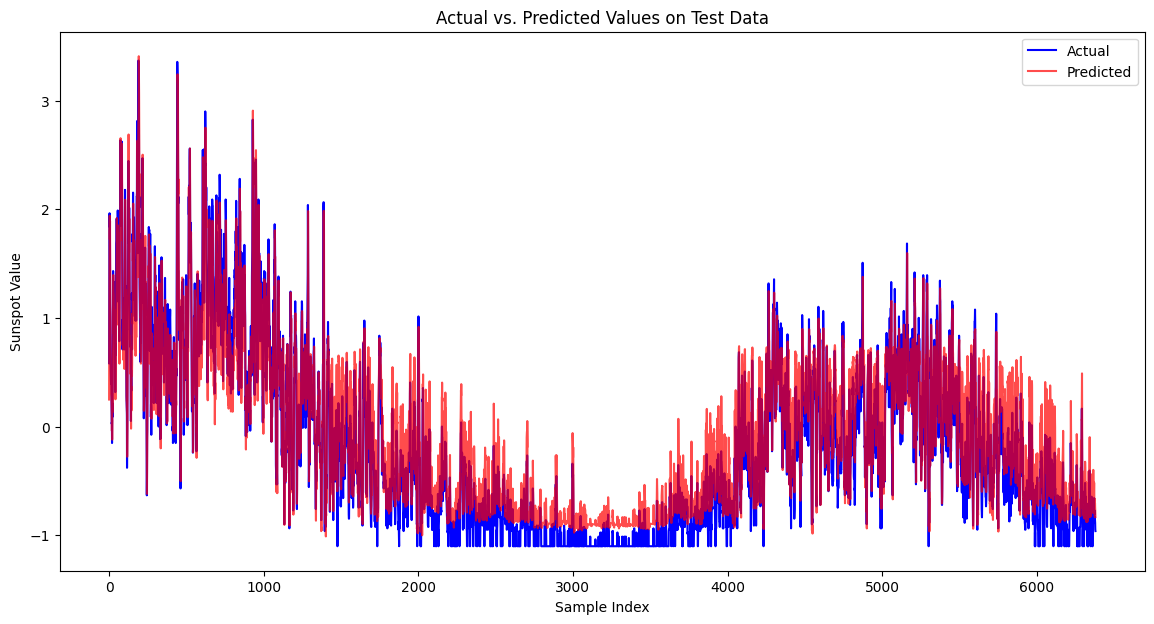

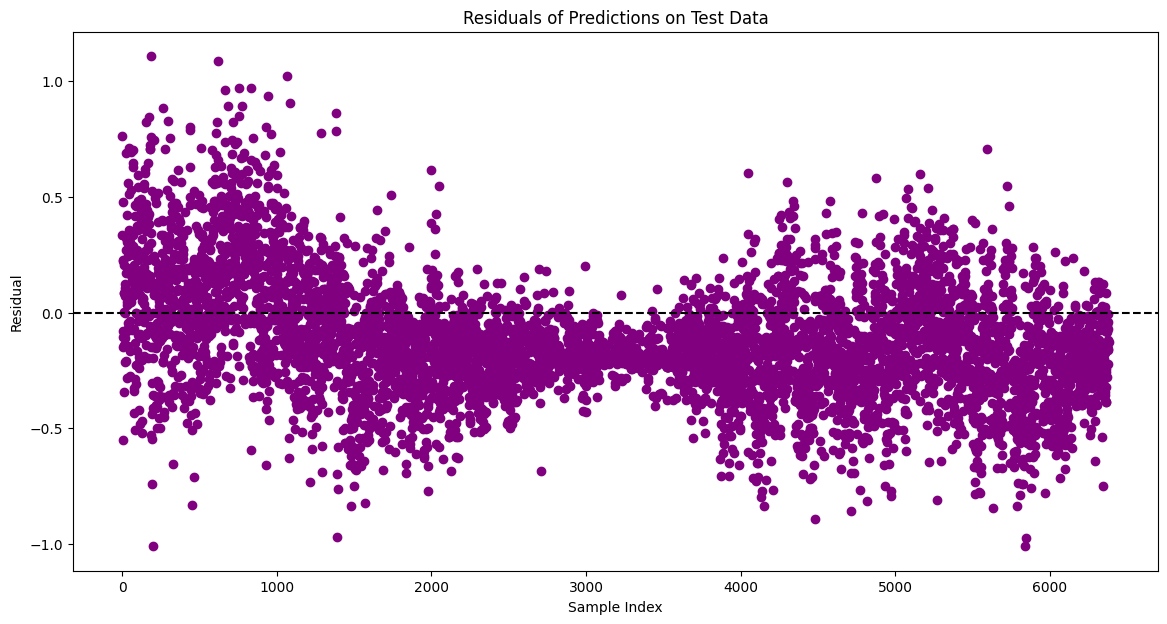

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Load and preprocess the dataset
names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

# Filter out the starting data point and convert 'sn_value' to float
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)

# Split into training and test sets based on year
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

# Extract 'sn_value' for training and testing
spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

# Standardize the data
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

# Create sequences for training and testing
sequence_length = 10  # Number of previous time steps to use for prediction
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(sequence_length, len(spots_train)):
    X_train.append(spots_train[i-sequence_length:i])
    y_train.append(spots_train[i])

for i in range(sequence_length, len(spots_test)):
    X_test.append(spots_test[i-sequence_length:i])
    y_test.append(spots_test[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN-Transformer hybrid model
class CNNTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, cnn_kernel_size=3, cnn_out_channels=64, dropout=0.1):
        super(CNNTransformer, self).__init__()
        
        # CNN Layer for feature extraction
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size, stride=1, padding=cnn_kernel_size//2)
        
        # Linear layer to project CNN output to the model dimension
        self.cnn_projection = nn.Linear(cnn_out_channels, d_model)
        
        # Positional encoding for the sequence
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, d_model))  # Adjusted for sequence length
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final output layer
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        # Reshape input to match (batch_size, feature_dim, sequence_length)
        src = src.permute(0, 2, 1)  # Change to (batch_size, feature_dim, sequence_length)
        
        # Apply CNN (output shape: (batch_size, cnn_out_channels, sequence_length))
        cnn_out = self.cnn(src)
        
        # Change shape back to (batch_size, sequence_length, cnn_out_channels)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # Project CNN output to model dimension
        cnn_out = self.cnn_projection(cnn_out)
        
        # Add positional encoding (broadcast across batch)
        src = cnn_out + self.positional_encoding
        
        # Transformer encoder
        out = self.transformer(src)
        
        # Pooling (mean across the sequence)
        out = out.mean(dim=1)
        
        # Final output layer
        return self.fc_out(out).squeeze(-1)

# Model hyperparameters
INPUT_DIM = 1  # One feature (time series value)
D_MODEL = 64  # Model dimension
NUM_HEADS = 4  # Number of attention heads
NUM_LAYERS = 2  # Number of transformer layers
DROPOUT = 0.1  # Dropout rate

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNTransformer(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert to numpy arrays for metric calculations
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Values on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Sunspot Value')
plt.legend()
plt.show()

# Plot residuals
residuals = y_true - y_pred

plt.figure(figsize=(14, 7))
plt.scatter(range(len(residuals)), residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predictions on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.show()


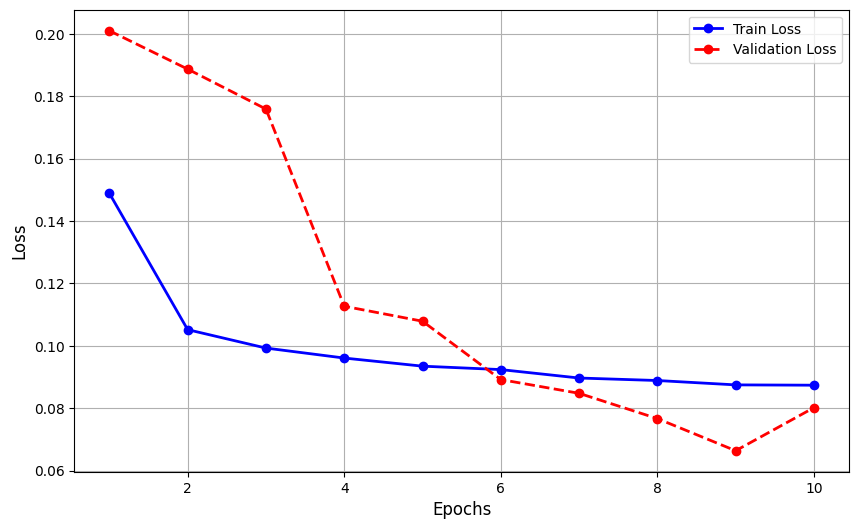

In [2]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Train and validation loss values
train_loss = [0.1489, 0.1052, 0.0993, 0.0961, 0.0935, 0.0924, 0.0897, 0.0889, 0.0875, 0.0874]
val_loss = [0.2010, 0.1887, 0.1759, 0.1127, 0.1079, 0.0892, 0.0848, 0.0767, 0.0664, 0.0802]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='b', linestyle='-', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='r', linestyle='--', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Training and Validation Loss for Solar Activity Forecasting', fontsize=14)
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('solar_activity_loss_plot.png')

# Show the plot
plt.show()
